# MIE1624 Assignment2: Ordinal Logistic Regression Algorithm

In [113]:
import numpy as np              
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,f1_score

from sklearn import metrics
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings("ignore")

In [114]:
df = pd.read_csv('clean_kaggle_data_2021.csv',low_memory=False)
df

,Time from Start to Finish (seconds),Q1,Q2,Q3,Q4,Q5,Q6,Q7_Part_1,Q7_Part_2,Q7_Part_3,...,Q38_B_Part_5,Q38_B_Part_6,Q38_B_Part_7,Q38_B_Part_8,Q38_B_Part_9,Q38_B_Part_10,Q38_B_Part_11,Q38_B_OTHER,Q25_Encoded,Q25_buckets
0,Duration (in seconds),What is your age (# years)?,What is your gender? - Selected Choice,In which country do you currently reside?,What is the highest level of formal education ...,Select the title most similar to your current ...,For how many years have you been writing code ...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,...,"In the next 2 years, do you hope to become mor...","In the next 2 years, do you hope to become mor...","In the next 2 years, do you hope to become mor...","In the next 2 years, do you hope to become mor...","In the next 2 years, do you hope to become mor...","In the next 2 years, do you hope to become mor...","In the next 2 years, do you hope to become mor...","In the next 2 years, do you hope to become mor...",NaN,NaN
1,910,50-54,Man,India,Bachelor’s degree,Other,5-10 years,Python,R,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,"20,000-29,999"
2,784,50-54,Man,Indonesia,Master’s degree,Program/Project Manager,20+ years,NaN,NaN,SQL,...,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,6.0,"60,000-69,999"
3,924,22-24,Man,Pakistan,Master’s degree,Software Engineer,1-3 years,Python,NaN,NaN,...,TensorBoard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,"0-9,999"
4,575,45-49,Man,Mexico,Doctoral degree,Research Scientist,20+ years,Python,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,3.0,"30,000-39,999"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15387,323,30-34,Man,India,Bachelor’s degree,Data Analyst,1-3 years,Python,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,"0-9,999"
15388,910,35-39,Man,South Korea,Bachelor’s degree,Software Engineer,5-10 years,Python,NaN,SQL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,"80,000-89,999"
15389,1756,30-34,Man,Egypt,Bachelor’s degree,Data Analyst,1-3 years,Python,NaN,SQL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,"10,000-19,999"
15390,494,50-54,Man,Sweden,Doctoral degree,Research Scientist,I have never written code,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,0.0,"0-9,999"


# 1. Data Cleaning

In [115]:
df = df.drop([0]) #drop specific question content

In [116]:
# See how many null values are in each column
df.isna().sum()

Time from Start to Finish (seconds)        0
Q1                                         0
Q2                                         0
Q3                                         0
Q4                                         0
                                       ...  
Q38_B_Part_10                          14089
Q38_B_Part_11                          12880
Q38_B_OTHER                            15177
Q25_Encoded                                0
Q25_buckets                                0
Length: 371, dtype: int64

In [117]:
df.dropna(axis='columns',how='any', thresh=9000, subset=None, inplace=True) #drop those questions with answers of nan

In [118]:
df.dropna(axis=0, how='any', thresh=20, subset=None, inplace=True) #drop never written code people

In [119]:
df.isna().sum()

Time from Start to Finish (seconds)       0
Q1                                        0
Q2                                        0
Q3                                        0
Q4                                        0
Q5                                        0
Q6                                        0
Q7_Part_1                              1796
Q8                                        0
Q9_Part_11                             4791
Q11                                       0
Q13                                       0
Q14_Part_1                             3611
Q15                                       0
Q16_Part_1                             5201
Q17_Part_1                             5156
Q20                                       0
Q21                                       0
Q22                                       0
Q23                                       0
Q25                                       0
Q26                                     165
Q41                             

In [120]:
#df['Q7_Part_1'].unique() #Python or other
df['Q7_Part_1'].fillna('Other',inplace=True)
#df['Q9_Part_11'].unique() #Jupyter Notebook or other
df['Q9_Part_11'].fillna('Other',inplace=True)
#df['Q14_Part_1'].unique() # Matplotlib or other
df['Q14_Part_1'].fillna('Other',inplace=True)
#df['Q16_Part_1'].unique() # Scikit-learn or other
df['Q16_Part_1'].fillna('Other',inplace=True)
#df['Q17_Part_1'].unique() Linear or Logistic Regression or other
df['Q17_Part_1'].fillna('Other',inplace=True)

#df['Q26'].value_counts(normalize=True) #5 years spending on ML/cloud, nan means they do not use ML/cloud, so no spending
df['Q26'].fillna(df['Q26'].mode()[0],inplace=True)

#df['Q41'].value_counts(normalize=True) #Contains 'other' answer, so simply use fillna
df['Q41'].fillna('Other',inplace=True)

In [121]:
# df.isna().sum() #double check: all filled, no nan

df['Q25']=df['Q25_Encoded']

#Categorical Encode
cols=list(df.columns)
cols.remove('Q25_buckets')
cols.remove('Q25_Encoded')

le = preprocessing.LabelEncoder()
for i in cols:
    df[i]=le.fit_transform(df[i])

df.head() #check

,Time from Start to Finish (seconds),Q1,Q2,Q3,Q4,Q5,Q6,Q7_Part_1,Q8,Q9_Part_11,...,Q17_Part_1,Q20,Q21,Q22,Q23,Q25,Q26,Q41,Q25_Encoded,Q25_buckets
1,3070,7,0,23,0,7,4,1,9,1,...,0,8,4,5,1,2,4,4,2.0,"20,000-29,999"
2,2866,7,0,24,3,9,2,0,9,0,...,0,8,2,1,2,6,0,0,6.0,"60,000-69,999"
3,3099,1,0,41,3,11,0,1,9,0,...,1,0,2,0,0,0,0,1,0.0,"0-9,999"
4,2482,6,0,34,1,10,2,1,9,0,...,1,0,2,0,0,3,0,4,3.0,"30,000-39,999"
5,2858,6,0,23,1,7,5,1,9,0,...,0,0,4,6,5,3,5,4,3.0,"30,000-39,999"


# 2. Explorary Data Analysis and Feature Selection

In [122]:
df=df.drop(['Time from Start to Finish (seconds)'],axis=1)

y = df['Q25']
X = df.drop(['Q25_Encoded','Q25_buckets','Q25'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=13)

#scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test)

df = df.drop(['Q25'],axis=1)

Text(0.5, 1.0, 'Correlation Matrix')

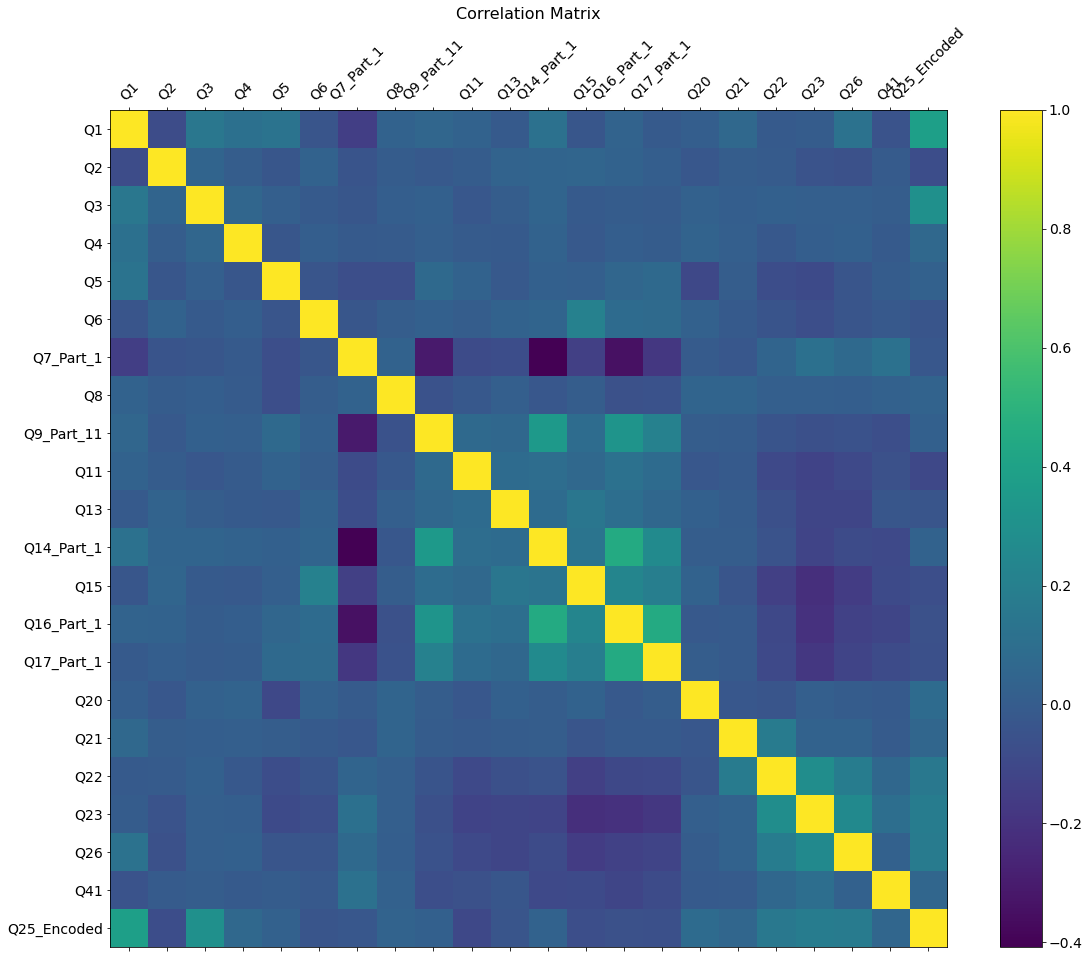

In [123]:
f = plt.figure(figsize=(19, 15))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)
#Q1&Q3 most correlatted to Q25

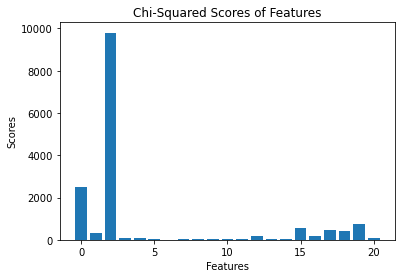

,feature_names,imp_score
0,Q1,2509.975088
1,Q2,313.884793
2,Q3,9796.073487
3,Q4,107.936289
4,Q5,62.953587
5,Q6,27.343560
6,Q7_Part_1,2.479783
7,Q8,15.803409
8,Q9_Part_11,15.964106
9,Q11,56.353063


In [124]:
#Using Chi-Squared Feature Selection
fs=SelectKBest(score_func=chi2, k='all')
fs.fit(X_train, y_train)
X_train_fs = fs.transform(X_train)
X_test_fs = fs.transform(X_test)

dft = df.drop(['Q25_Encoded','Q25_buckets'],axis=1)

importance=[]
# what are scores for the features
for i in range(len(fs.scores_)):
    importance.append(fs.scores_[i])
# plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.title('Chi-Squared Scores of Features')
plt.xlabel('Features')
plt.ylabel('Scores')
plt.show()

imp = pd.DataFrame({'feature_names': dft.columns,'imp_score':importance})
imp

In [125]:
#Drop unimportant features
del_col = [4,5,6,7,8,9,10,11,13,14,20]
del_colname = ['Q5','Q6','Q7_Part_1','Q8','Q9_Part_11','Q11','Q13','Q14_Part_1','Q16_Part_1','Q17_Part_1','Q41',]
for i in del_col:
    imp = imp.drop(i)
for j in del_colname:
    X_train = X_train.drop([j],axis=1)
    X_test = X_test.drop([j],axis=1)
    
imp.reset_index(drop=True, inplace=True)

print(X_train.shape)
print(X_test.shape)

(9974, 10)
(4275, 10)


# 3. Model Implementation

In [126]:
y_train.unique()
Y = y_train.copy()

In [127]:
#define a encode function to deal with ordinal multi-class targets
#for example, make all class0 still '0', and make the rest class1 to class 14 as '1'
#it helps for further 15 binary classifications
def re_encode(y_temp,n):
    for i in range(len(y_temp)):
        if y_temp.values[i]<=n:
            y_temp.values[i]=0
            i+=1
        else:
            y_temp.values[i]=1
            i+=1    

In [128]:
#define a function to re-encode all target class into 0 and 1, make them become 15 individual binary classfications
#then put into sklearn logistic_regression function
def ordinal_logit(model,X_t,y_t,X_val):
    #For class 0 and others:
        #first encode
    y_train_tep0 = y_t.copy()

    re_encode(y_train_tep0,0)
        #get probability
    
    model.fit(X_t,y_train_tep0)
    class_0 = model.predict_proba(X_val)
    class_0 = class_0[:,0]

    # Create a probability dataframe
    df_prob = pd.DataFrame(class_0,columns=['Class0'])
    
    #For class 1 to 13
    class_tep = class_0
    for i in range(1,14): 
        y_train_tep = y_t.copy()
        re_encode(y_train_tep,i)
        #get probability
        model.fit(X_t,y_train_tep)
        class_cum = model.predict_proba(X_val)
        if i==13:
            class_14 = class_cum[:,1]
        class_cum = class_cum[:,0]

        #get difference
        diff = np.subtract(class_cum,class_tep)
        class_tep = class_cum.copy()
        #save diff in dataframe
        df_prob['Class'+str(i)]=diff

    #For class 14 and others：
    df_prob['Class14']=class_14

    #Get predictions for X_train
    y_pred = []
    cl = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]
    
    for i in range(len(X_val)):
        c = np.argmax(df_prob.values[i,:])
        y_pred.append(cl[c])

    y_pred = np.array(y_pred)
    
    return df_prob, y_pred

In [129]:
#define a function for 10_folds cross validation
def run_kfold(model,X_train,Y):
    
    kf = KFold(n_splits=10) #n_splits previously n_folds
    
    outcomes = []
    fold = 0
    
    X = X_train.copy()
    for train_index, test_index in kf.split(X):
        fold += 1
        X_tr, X_te = X.values[train_index], X.values[test_index] 
        Y_tr, Y_te = Y.values[train_index], Y.values[test_index] 
        
        X_trpd = pd.DataFrame(data=X_tr)
        X_tepd = pd.DataFrame(data=X_te)
        Y_trpd = pd.DataFrame(data=Y_tr)
        Y_tepd = pd.DataFrame(data=Y_te)
        

        df_prob, predictions = ordinal_logit(model,X_trpd,Y_trpd,X_tepd)
        
        accuracy = accuracy_score(Y_te, predictions) 
        outcomes.append(accuracy)
        print("Fold {0} accuracy: {1}".format(fold, accuracy))   
        
    mean_outcome = np.mean(outcomes)
    var_outcome=np.var(outcomes)
    print("Mean Accuracy: {0}".format(mean_outcome)) 
    print("Variance: {0}".format(var_outcome))


In [130]:
lr = linear_model.LogisticRegression()
run_kfold(lr,X_train,Y)

Fold 1 accuracy: 0.4348697394789579
Fold 2 accuracy: 0.46092184368737477
Fold 3 accuracy: 0.4438877755511022
Fold 4 accuracy: 0.4649298597194389
Fold 5 accuracy: 0.4483450351053159
Fold 6 accuracy: 0.436308926780341
Fold 7 accuracy: 0.4272818455366098
Fold 8 accuracy: 0.43931795386158473
Fold 9 accuracy: 0.45135406218655966
Fold 10 accuracy: 0.45336008024072216
Mean Accuracy: 0.44605771221480073
Variance: 0.00012865837923721168


In [149]:
#Add standardization to cross validations to see difference
scaler = StandardScaler()

def run_kfold_scaler(model,X_train,Y):
    
    kf = KFold(n_splits=10) #n_splits previously n_folds
    
    outcomes = []
    fold = 0
    
    X = X_train.copy()
    X = scaler.fit_transform(X)
    
    X = pd.DataFrame(data=X)

    for train_index, test_index in kf.split(X):
        fold += 1
        X_tr, X_te = X.values[train_index], X.values[test_index] 
        Y_tr, Y_te = Y.values[train_index], Y.values[test_index] 
        
        X_trpd = pd.DataFrame(data=X_tr)
        X_tepd = pd.DataFrame(data=X_te)
        Y_trpd = pd.DataFrame(data=Y_tr)
        Y_tepd = pd.DataFrame(data=Y_te)
        

        df_prob, predictions = ordinal_logit(model,X_trpd,Y_trpd,X_tepd)
        
        accuracy = accuracy_score(Y_te, predictions) 
        outcomes.append(accuracy)
        print("Fold {0} accuracy: {1}".format(fold, accuracy))   
        
    mean_outcome = np.mean(outcomes)
    var_outcome=np.var(outcomes)
    print("Mean Accuracy: {0}".format(mean_outcome)) 
    print("Variance: {0}".format(var_outcome))


In [132]:
lr = linear_model.LogisticRegression()
run_kfold_scaler(lr,X_train,Y)

Fold 1 accuracy: 0.4348697394789579
Fold 2 accuracy: 0.46092184368737477
Fold 3 accuracy: 0.4438877755511022
Fold 4 accuracy: 0.46392785571142287
Fold 5 accuracy: 0.4483450351053159
Fold 6 accuracy: 0.436308926780341
Fold 7 accuracy: 0.4282848545636911
Fold 8 accuracy: 0.43931795386158473
Fold 9 accuracy: 0.45135406218655966
Fold 10 accuracy: 0.45336008024072216
Mean Accuracy: 0.44605781271670725
Variance: 0.00012131091689935623


In [133]:
#Implement the simplest model with only one hyperparameter tuning, keep all other parameters as default
def tuning_c_kfolds(X_train,Y):
    
    kf = KFold(n_splits=10)
    
    X = X_train.copy()
    
    all_mean_tr = []
    all_mean_val = []
    
    for C in [0.001,0.01,0.1,1,10,100]:
        model = LogisticRegression(C=C)
        outcomes_tr = []
        outcomes_val = []
                                   
        for train_index, test_index in kf.split(X):
            X_tr, X_te = X.values[train_index], X.values[test_index] 
            Y_tr, Y_te = Y.values[train_index], Y.values[test_index] 
        
            X_trpd = pd.DataFrame(data=X_tr)
            X_tepd = pd.DataFrame(data=X_te)
            Y_trpd = pd.DataFrame(data=Y_tr)
            Y_tepd = pd.DataFrame(data=Y_te)
        

            df_prob_val, predictions_val = ordinal_logit(model,X_trpd,Y_trpd,X_tepd)
            df_prob_tr, predictions_tr = ordinal_logit(model,X_trpd,Y_trpd,X_trpd)
        
            acc_val = accuracy_score(Y_te, predictions_val)
            acc_tr = accuracy_score(Y_tr, predictions_tr)
            outcomes_val.append(acc_val) 
            outcomes_tr.append(acc_tr)
        
        c_params = C
        mean_val = np.mean(outcomes_val)
        mean_tr = np.mean(outcomes_tr)
        all_mean_tr.append(mean_tr)
        all_mean_val.append(mean_val)
        
        print ("For C={}, the validation accuracy is {}, train accuracy is {}".format(c_params,round(mean_val,4), round(mean_tr,4)))
    return all_mean_tr, all_mean_val

In [134]:
all_mean_tr, all_mean_val = tuning_c_kfolds(X_train,y_train) 
#It takes some moment to running 10_folds and 6 times iterated C value 

For C=0.001, the validation accuracy is 0.4486, train accuracy is 0.4491
For C=0.01, the validation accuracy is 0.447, train accuracy is 0.4476
For C=0.1, the validation accuracy is 0.446, train accuracy is 0.4473
For C=1, the validation accuracy is 0.4461, train accuracy is 0.4473
For C=10, the validation accuracy is 0.4461, train accuracy is 0.4473
For C=100, the validation accuracy is 0.4461, train accuracy is 0.4473


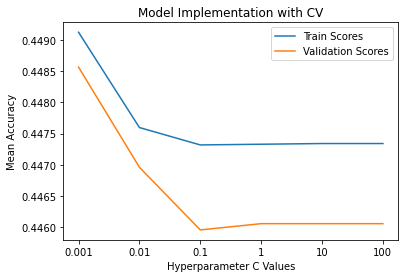

In [135]:
#plot training scores and validation scores
c_list = [0.001,0.01,0.1,1,10,100]
plt.plot(all_mean_tr, label = 'Train Scores')
plt.plot(all_mean_val, label = 'Validation Scores')
plt.xlabel('Hyperparameter C Values')
plt.ylabel('Mean Accuracy')
plt.title('Model Implementation with CV')
plt.xticks(range(len(all_mean_tr)),c_list)
plt.legend()
plt.show()

# 4. Model Tuning

C: float, default=1.0 Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization.

Regularization generally refers the concept that there should be a complexity penalty for more extreme parameters. The idea is that just looking at the training data and not paying attention to how extreme one's parameters are leads to overfitting. A high value of C tells the model to give high weight to the training data, and a lower weight to the complexity penalty. A low value tells the model to give more weight to this complexity penalty at the expense of fitting to the training data. Basically, a high C means "Trust this training data a lot", while a low value says "This data may not be fully representative of the real world data, so if it's telling you to make a parameter really large, don't listen to it".

In [136]:
#Manual grid search for iterating predetermined hyperparameters and compare accuracy to get the best model
kfold = KFold(n_splits=10)
X1 = X_train.copy()
Y1 = y_train.copy()
kfold.get_n_splits(X)

best_model = LogisticRegression()
best_params = {}
best_accuracy = 0
best_std = 0

for C in [0.001,0.01,0.1,1,10,100]:
    for solver in ['newton-cg','lbfgs','liblinear','sag']:
        
        model = LogisticRegression(C=C, solver=solver,random_state=0)
        acc_list = []
        
        for train_index, test_index in kfold.split(X1):
            X_tr1, X_val1 = X1.values[train_index], X1.values[test_index] 
            Y_tr1, Y_val1 = Y1.values[train_index], Y1.values[test_index] 
        
            X_trpd1 = pd.DataFrame(data=X_tr1)
            X_valpd1 = pd.DataFrame(data=X_val1)
            Y_trpd1 = pd.DataFrame(data=Y_tr1)
            Y_valpd1 = pd.DataFrame(data=Y_val1)
        
            df_prob, prediction_val = ordinal_logit(model,X_trpd1,Y_trpd1,X_valpd1)
        
            acc = f1_score(Y_val1, prediction_val, average='micro')
            
            acc_list.append(acc)
        
        if np.mean(acc_list) > best_accuracy:
            best_model = model
            best_params = {'C':C, 'solver':solver}
            best_accuracy = np.mean(acc_list)
            best_std = np.std(acc_list)

print (best_params)
print ("Best Score: {}%(std:{})".format(round(best_accuracy*100,3),round(best_std,3)))      

print ("\nThe optimal logistic model uses C={}, and a {} solver, and has a cross validation score of {}% with a standard deviation of {}".format(best_params['C'],best_params['solver'],round(best_accuracy*100,3),round(best_std,3)))

{'C': 0.001, 'solver': 'sag'}
Best Score: 44.867%(std:0.011)

The optimal logistic model uses C=0.001, and a sag solver, and has a cross validation score of 44.867% with a standard deviation of 0.011


In [142]:
#Feature importance
lr = linear_model.LogisticRegression(C=0.001,solver='sag')
df_prob_t, t_pred = ordinal_logit(lr,X_train,y_train,X_train)

train_df = X_train.copy()
train_df['Q25']=t_pred

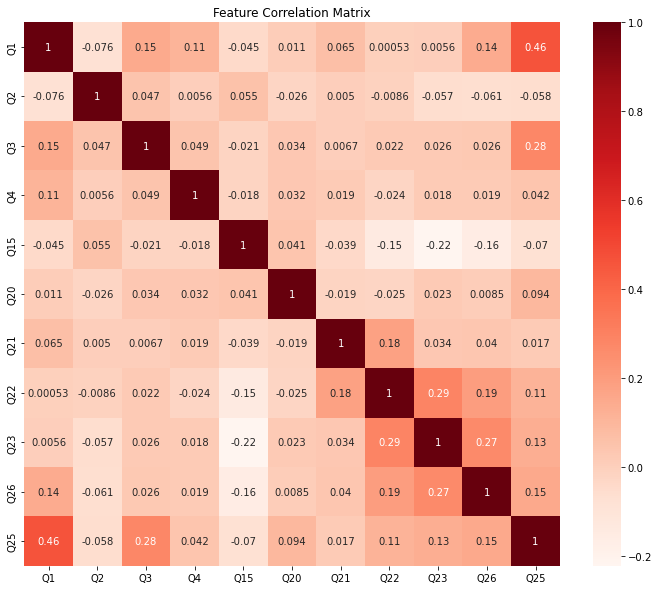

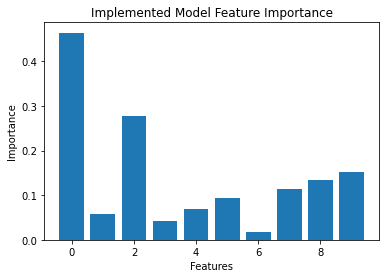

In [143]:
#Plot feature improtance given the optimal model
plt.figure(figsize=(12,10))
cor = train_df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.title('Feature Correlation Matrix')
plt.show()

cor_target = abs(cor['Q25'])
cor_target = cor_target[0:-1] #drop target correlatio

plt.bar([i for i in range(len(cor_target))], cor_target)
plt.title('Implemented Model Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

# 5. Testing and Discussion

In [144]:
#Optimal Model performance on test data:
opt = LogisticRegression(C=0.001,solver='sag')
df_prob_test,test_pred = ordinal_logit(opt,X_train,y_train,X_test)
test_score = f1_score(y_test, test_pred, average='micro')
print('Optimal model implementing on test set accuracy:{}%'.format(round(test_score*100,3)))

Optimal model implementing on test set accuracy:42.994%


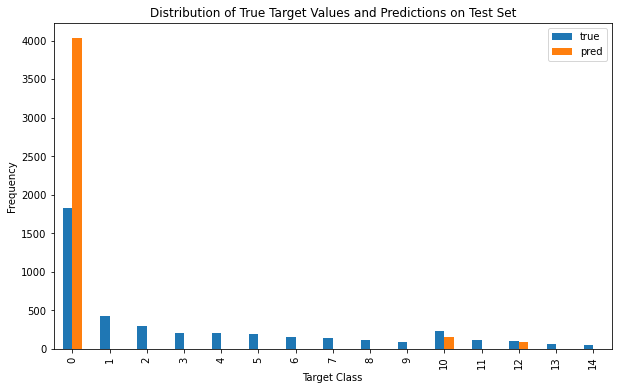

In [147]:
#Test set target distributions:
ytest = y_test.copy()
test_pred = pd.DataFrame(data = test_pred, index = y_test.index, columns=['pred'])
test_pred['true']=ytest

d = {"true":test_pred['true'].value_counts().sort_index(),"pred":test_pred['pred'].value_counts().sort_index()}
test_df = pd.DataFrame(data = d)
test_df.plot.bar(figsize=(10,6))
plt.xlabel("Target Class")
plt.ylabel("Frequency")
plt.title('Distribution of True Target Values and Predictions on Test Set')
plt.show()

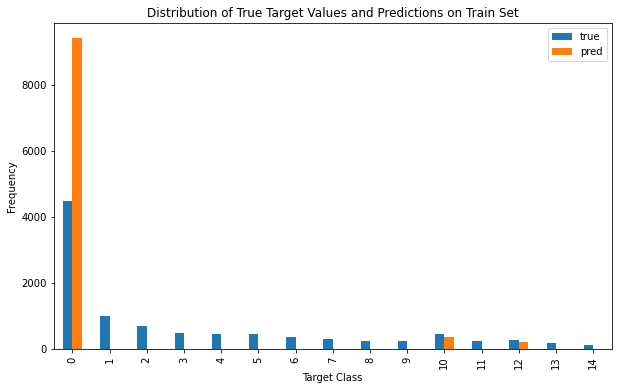

In [148]:
#Training set target distributions:
opt = LogisticRegression(C=0.001,solver='sag')
df_prob_train,train_pred = ordinal_logit(opt,X_train,y_train,X_train)

ytrain = y_train.copy()
train_pred = pd.DataFrame(data = train_pred, index = y_train.index, columns=['pred'])
train_pred['true']=ytrain

e = {"true":train_pred['true'].value_counts().sort_index(),"pred":train_pred['pred'].value_counts().sort_index()}
train_df = pd.DataFrame(data = e)
train_df.plot.bar(figsize=(10,6))
plt.xlabel("Target Class")
plt.ylabel("Frequency")
plt.title('Distribution of True Target Values and Predictions on Train Set')
plt.show()